In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
import numpy as np
import scipy.stats as st
import torch
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader
from tqdm.auto import trange

from mixmil import MixMIL
from mixmil.data import MILDataset, load_data
from mixmil.utils import regressOut
from mixmil.data import xgower_factor
from sklearn.linear_model import LogisticRegressionCV

import matplotlib.pyplot as plt
import pandas as pd



array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

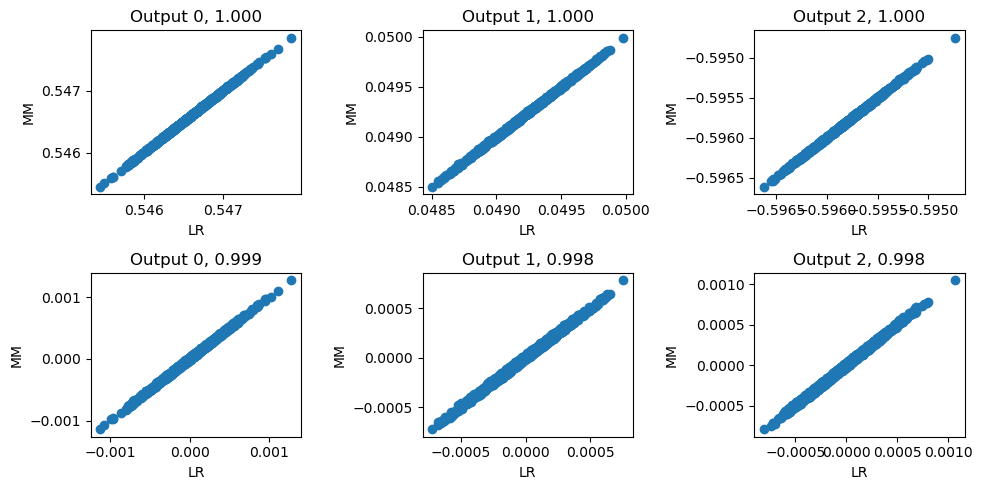

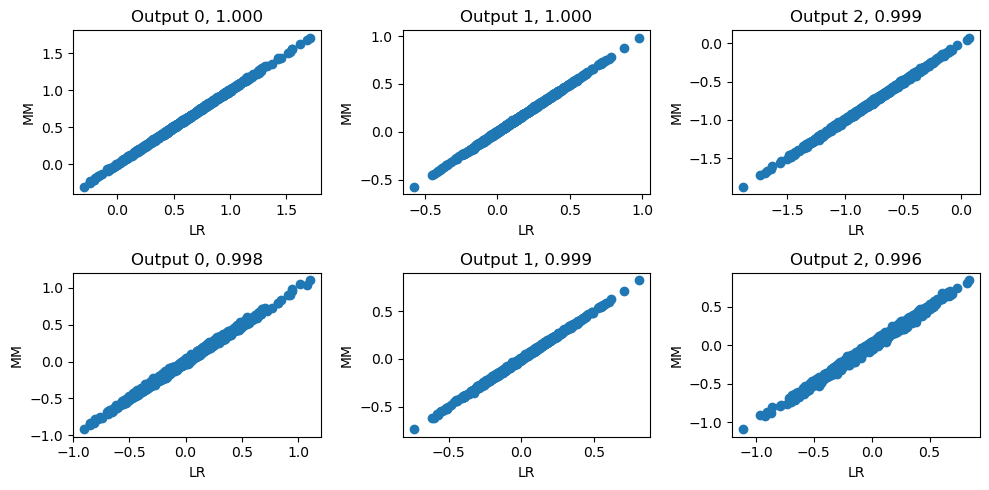

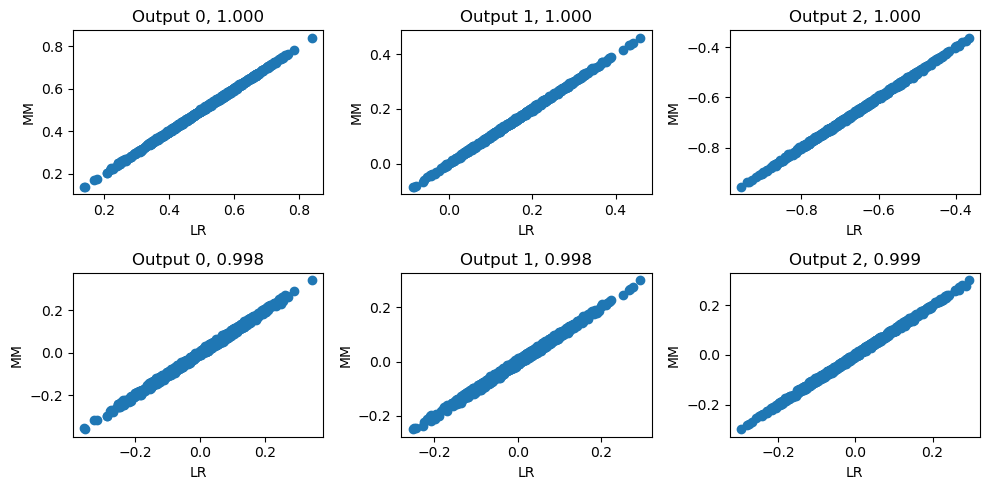

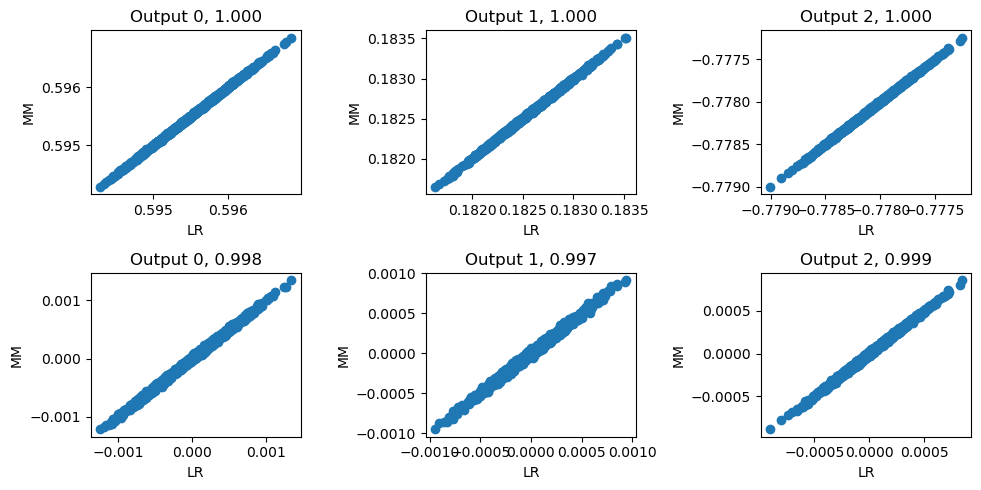

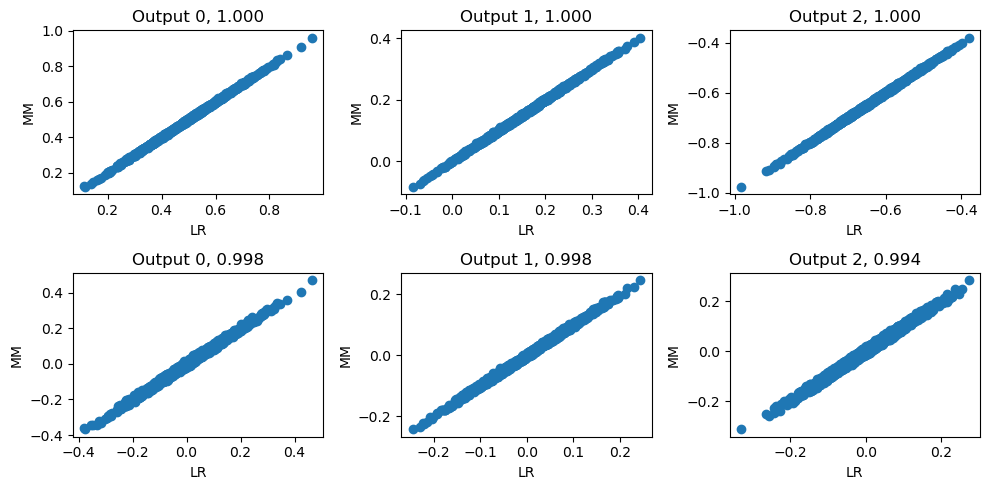

In [21]:
for seed in  [2343, 2344, 2345, 2346, 2347]:
    N = 1000
    P = 1

    F = torch.Tensor(pd.get_dummies(np.array(([0]* 300 + [1]*500 + [2]*400))).values.astype(int))
    F = torch.cat([F, torch.randn(F.shape[0], 1)], dim=1)
    X, F, Y, u, w = load_data(N=1000, P=P, F=F, seed=seed)
    Xs, F, Y = X["train"], F["train"], Y["train"]
    model = MixMIL.init_with_mean_model(Xs, F, Y, likelihood="categorical")


    Xm = np.concatenate([x.mean(0, keepdims=True).numpy() for x in Xs], axis=0)
    Xmog = (Xm - Xm.mean(0, keepdims=True)) / (Xm.std(0, keepdims=True) * np.sqrt(30))
    idx = np.concatenate([np.full(x.shape[0], i) for i, x in enumerate(Xs)], axis=0)
    Fr = np.concatenate([F[[i]] for i in idx], axis=0)
    Xr = np.concatenate(Xs, axis=0) if isinstance(Xs, list) else Xs.reshape(-1, Xs.shape[-1])
    Xr, b, Fiv = regressOut(Xr, Fr, return_b=True, return_pinv=True)
    Xs = [Xr[idx == i] for i in range(idx.max() + 1)]

    Xm = np.concatenate([x.mean(0, keepdims=True).numpy() for x in Xs], axis=0)
    Xm = (Xm - Xm.mean(0, keepdims=True)) / xgower_factor(Xm)
    Fe, Ye = F.numpy(), Y.long().numpy()


    lr = LogisticRegressionCV(
        Cs=10,
        fit_intercept=True,
        penalty="l2",
        multi_class="multinomial",
        solver="lbfgs",
        n_jobs=8,
        verbose=0,
        random_state=42,
        max_iter=1000,
        refit=True,
    )

    lr.fit(Xm, Ye.ravel())

    lrpreds = Xm.dot(lr.coef_.T)
    flrpreds = lrpreds + lr.intercept_

    mmpreds = model.predict(torch.Tensor(Xmog).reshape(-1, 1, 30))
    with torch.no_grad():
        fmmpred = torch.Tensor(Fe).mm(model.alpha) + mmpreds


    fig, axes = plt.subplots(2, 3, figsize=(10, 5))
    for i in range(3):
        ax = axes[0, i]
        ax.scatter(flrpreds[:, i], fmmpred[:, i])
        ax.set_xlabel("LR")
        ax.set_ylabel("MM")
        ax.set_title(f"Output {i}, {st.pearsonr(flrpreds[:, i], fmmpred[:, i])[0]:.3f}")

        ax = axes[1, i]
        ax.scatter(lrpreds[:, i], mmpreds[:, i])
        ax.set_xlabel("LR")
        ax.set_ylabel("MM")
        ax.set_title(f"Output {i}, {st.pearsonr(lrpreds[:, i], mmpreds[:, i])[0]:.3f}")
    fig.tight_layout()